### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta, date
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
import scipy.stats as ss

%matplotlib inline

In [2]:
# Setting option to display all columns for dataframes
pd.set_option('display.max_columns', None)

# Charts style in seaborn
sns.set_style(style='white', rc=None)

### Import data from tweets

Let's start by importing our processed data and see how many tweets we have for each stock.

In [3]:
stocks_merged = pd.read_csv('..\data\stocks_merged.csv', index_col=0, parse_dates=['datetime'])
stocks_merged.shape

(16327, 24)

In [4]:
# Breakdown of tweets by stock
stocks_merged.groupby('stock').count()['price_movement']

stock
GOOGL    7876
JPM      4503
XOM      3948
Name: price_movement, dtype: int64

In [5]:
stocks_merged.head(1)

,datetime,text,username,likeCount,replyCount,retweetCount,stock,date_x,hour,minutes,dayofweek,predictiondate,price_movement,processed_text,tickers,number_tickers,hashtags,number_hashtags,mentions,number_mentions,text_length,lem_text,sentiment_label,sentiment_score
0,2018-12-30 20:50:51-05:00,$GOOGL Chicago District judge Edmond Chang dis...,Trade_The_News,1,0,0,GOOGL,2018-12-30,20,50,6,2018-12-31,1,$googl chicago district judge edmond chang dis...,['$googl'],1,[],0,[],0,185,$googl chicago district judge edmond chang dis...,neutral,0.781874


Let's drop some columns we will not use for the EDA and store our lemmatized text in a separate dataframe. We'll also store the text with username and dates for other analysis.

In [6]:
stocks_text = stocks_merged[['stock','lem_text','price_movement']]
stocks_text_username_date = stocks_merged[['stock','username','date_x','lem_text','price_movement']]

In [7]:
stocks_merged = stocks_merged.drop(columns=['datetime','text','replyCount','retweetCount','predictiondate',\
                                          'processed_text','tickers','number_tickers','lem_text','hashtags','mentions'])
stocks_merged.head(1)

,username,likeCount,stock,date_x,hour,minutes,dayofweek,price_movement,number_hashtags,number_mentions,text_length,sentiment_label,sentiment_score
0,Trade_The_News,1,GOOGL,2018-12-30,20,50,6,1,0,0,185,neutral,0.781874


Segmenting numerical and categorical columns in case we need it later.

In [8]:
# Segmenting numerical and categorical columns

num_cols = stocks_merged.select_dtypes(include=['number']).columns.tolist()
cat_cols = stocks_merged.select_dtypes(include=['object', 'category']).columns.tolist()

print(num_cols)
print(cat_cols)

['likeCount', 'hour', 'minutes', 'dayofweek', 'price_movement', 'number_hashtags', 'number_mentions', 'text_length', 'sentiment_score']
['username', 'stock', 'date_x', 'sentiment_label']


### Stock historical price change

We'll download and chart the historical price changes for the stocks as a reference.

In [9]:
googl_stock = yf.download(tickers = 'GOOGL', start='2018-01-01', end='2022-12-31', interval = '1d', rounding=True)
xom_stock = yf.download(tickers = 'XOM', start='2018-01-01', end='2022-12-31', interval = '1d', rounding=True)
jpm_stock = yf.download(tickers = 'JPM', start='2018-01-01', end='2022-12-31', interval = '1d', rounding=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


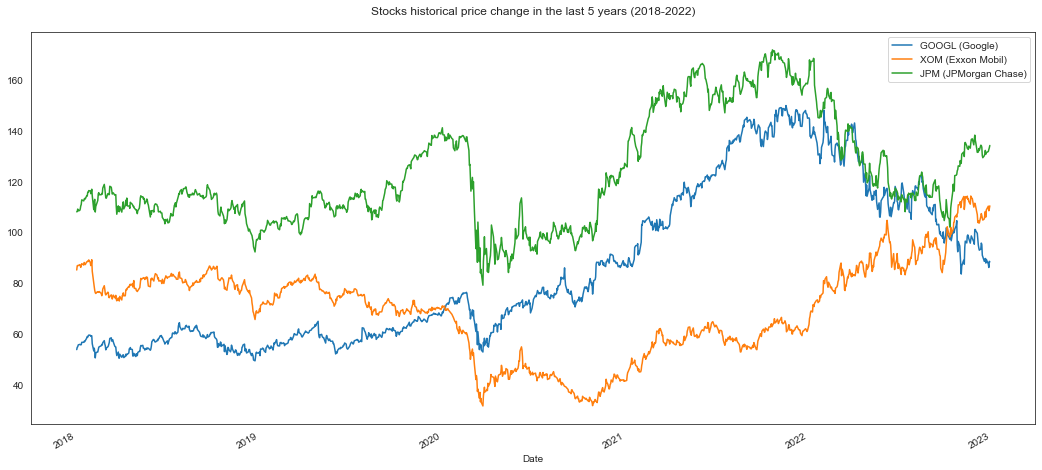

In [10]:
plt.figure(figsize=(18,8))
googl_stock['Close'].plot(label='GOOGL (Google)')
xom_stock['Close'].plot(label='XOM (Exxon Mobil)')
jpm_stock['Close'].plot(label='JPM (JPMorgan Chase)')
plt.legend()
plt.title('Stocks historical price change in the last 5 years (2018-2022)\n');

In [11]:
jpm_stock

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02 00:00:00-05:00,107.63,108.02,106.81,107.95,92.70,13578800
2018-01-03 00:00:00-05:00,107.86,108.49,107.48,108.06,92.79,11901000
2018-01-04 00:00:00-05:00,108.36,110.03,108.20,109.04,94.12,12953700
2018-01-05 00:00:00-05:00,109.26,109.55,107.78,108.34,93.52,14155000
2018-01-08 00:00:00-05:00,108.15,108.68,107.70,108.50,93.66,12466500
...,...,...,...,...,...,...
2022-12-23 00:00:00-05:00,130.58,131.44,129.64,131.28,130.32,5091900
2022-12-27 00:00:00-05:00,131.57,132.22,130.55,131.74,130.77,5411000
2022-12-28 00:00:00-05:00,131.85,133.41,131.01,132.46,131.49,8827700


### EDA - features other than tweet text

#### Price movement (target variable)

In [12]:
stocks = ['GOOGL', 'XOM', 'JPM']

In [13]:
for stock in stocks:
    print(f'\n{stock}\n',stocks_merged[stocks_merged.stock == stock]['price_movement'].value_counts(normalize=True))


GOOGL
 1    0.610843
0    0.389157
Name: price_movement, dtype: float64

XOM
 1    0.575228
0    0.424772
Name: price_movement, dtype: float64

JPM
 1    0.578725
0    0.421275
Name: price_movement, dtype: float64


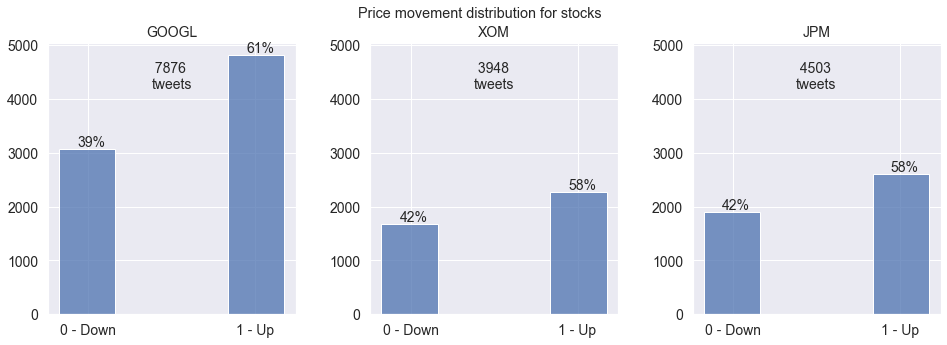

In [14]:
sns.set(rc={'figure.figsize':(16, 5)})
fig, ax = plt.subplots(1, 3, sharey=True)
fig.suptitle('Price movement distribution for stocks\n')

for i, stock in enumerate(stocks):
    sns.histplot(data=stocks_merged[stocks_merged['stock'] == stock], x='price_movement', ax=ax[i], binwidth=0.25)
    ax[i].set_title(stock, fontdict={'fontsize':14})
    ax[i].yaxis.set_tick_params(labelbottom=True)
    ax[i].set_xticks(ticks=[0.13,0.87], labels=['0 - Down','1 - Up'], fontsize=13)
    ax[i].tick_params(axis='both', labelsize=14)
    ax[i].set_xlabel(None)
    ax[i].set_ylabel(None)

ax[0].annotate('39%', (0.08,3130), fontsize=14)
ax[0].annotate('61%', (0.83,4870), fontsize=14)
ax[0].annotate(' 7876\ntweets', (0.41,4200), fontsize=14)

ax[1].annotate('42%', (0.08,1730), fontsize=14)
ax[1].annotate('58%', (0.83,2320), fontsize=14)
ax[1].annotate(' 3948\ntweets', (0.41,4200), fontsize=14)

ax[2].annotate('42%', (0.08,1950), fontsize=14)
ax[2].annotate('58%', (0.83,2650), fontsize=14)
ax[2].annotate(' 4503\ntweets', (0.41,4200), fontsize=14)

plt.subplots_adjust(wspace=0.3)  
plt.show();

#### Username

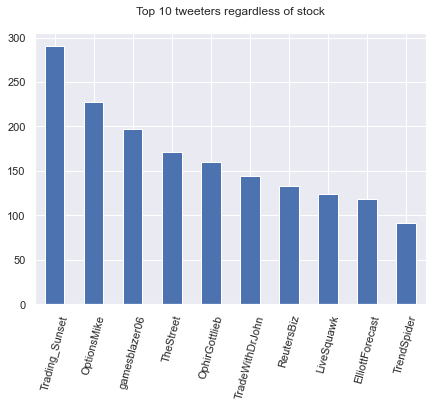

In [15]:
plt.figure(figsize=(7,5))
stocks_merged.groupby('username').count()['price_movement'].sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 tweeters regardless of stock\n')
plt.xlabel(None)
plt.xticks(rotation=75);

Let's explore the top tweet usernames by stock

In [16]:
def plot_usernames(stock):
    sns.set(rc={'figure.figsize':(16, 5)})
    fig, ax = plt.subplots(1, 2, sharey=True)
    fig.suptitle(stock)

    stocks_merged[(stocks_merged.stock == stock) & (stocks_merged.price_movement == 1)].\
            groupby('username').count()['price_movement'].sort_values(ascending=False).head(10).plot(kind='bar', ax=ax[0])
    ax[0].title.set_text('Top 10 usernames for price going UP')
    ax[0].set_xlabel(None)
    ax[0].xaxis.set_tick_params(labelrotation=75)

    stocks_merged[(stocks_merged.stock == stock) & (stocks_merged.price_movement == 0)].\
            groupby('username').count()['price_movement'].sort_values(ascending=False).head(10).plot(kind='bar', ax=ax[1])
    ax[1].title.set_text('Top 10 usernames for price going DOWN')
    ax[1].set_xlabel(None)
    ax[1].yaxis.set_tick_params(labelbottom=True)
    ax[1].xaxis.set_tick_params(labelrotation=75)

    plt.subplots_adjust(wspace=0.2)  
    plt.show();

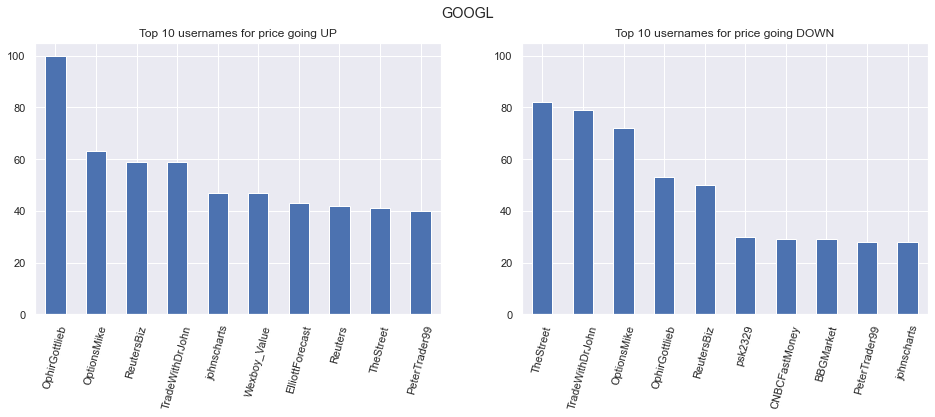

In [17]:
plot_usernames('GOOGL')

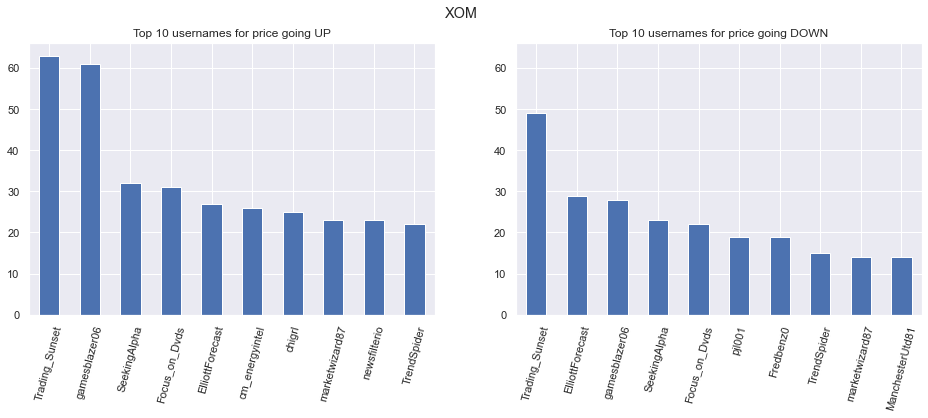

In [18]:
plot_usernames('XOM')

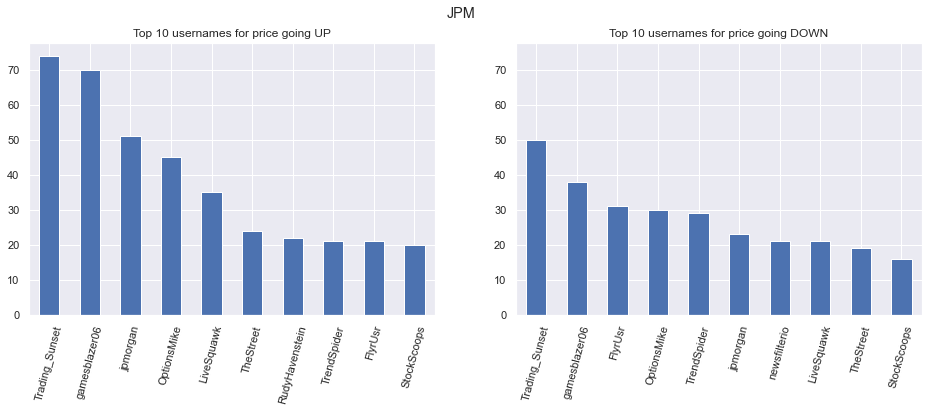

In [19]:
plot_usernames('JPM')

#### likeCount

In [20]:
stocks_merged.likeCount.value_counts(normalize=True).head(5)

1    0.331965
2    0.155693
3    0.101243
4    0.062963
5    0.047222
Name: likeCount, dtype: float64

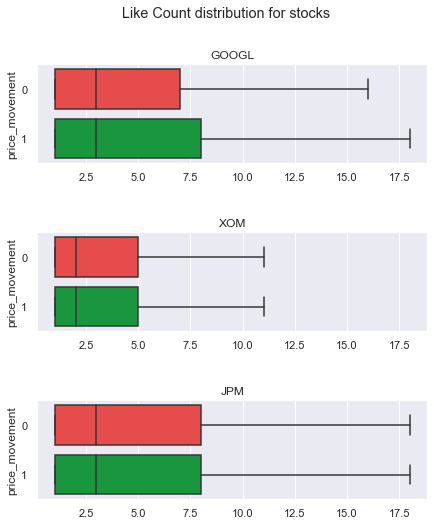

In [21]:
sns.set(rc={'figure.figsize':(7, 8)})
fig, ax = plt.subplots(3,1, sharex=True)
fig.suptitle('Like Count distribution for stocks')

for i, stock in enumerate(stocks):
    sns.boxplot(data=stocks_merged[stocks_merged.stock == stock], x='likeCount', y='price_movement', \
                orient='h', showfliers=False, palette=['#FF3333','#05AB37'], ax=ax[i])
    ax[i].title.set_text(stock)
    ax[i].xaxis.set_tick_params(labelbottom=True)
    ax[i].set_xlabel(None)

plt.subplots_adjust(hspace=0.7)  
plt.show();

#### hour

# NEW

In [22]:
def get_hours(df):
    
    hours_df = pd.DataFrame(np.arange(1,25), columns=['hour'])
    hours_df['price_up_count'] = df[df['price_movement'] == 1].\
                                groupby('hour').count()['likeCount'].sort_index().values
    hours_df['price_down_count'] = df[df['price_movement'] == 0].\
                                groupby('hour').count()['likeCount'].sort_index().values

    hours_df['total_tweets'] = hours_df['price_up_count'] + hours_df['price_down_count']
    
    return hours_df

In [23]:
googl_hours_df = get_hours(stocks_merged[stocks_merged['stock'] == 'GOOGL'])
xom_hours_df = get_hours(stocks_merged[stocks_merged['stock'] == 'XOM'])
jpm_hours_df = get_hours(stocks_merged[stocks_merged['stock'] == 'JPM'])

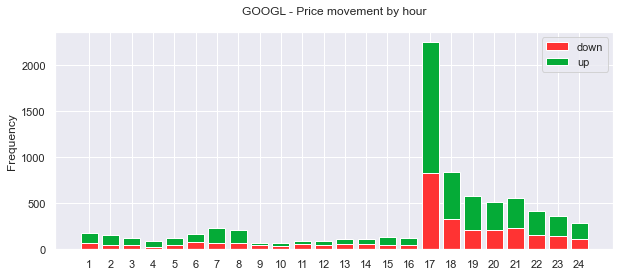

In [24]:
plt.figure(figsize=(10,4))
plt.bar(googl_hours_df['hour'], googl_hours_df['price_down_count'], color='#FF3333', label='down')
plt.bar(googl_hours_df['hour'], googl_hours_df['price_up_count'], bottom=googl_hours_df['price_down_count'], color='#05AB37', label='up')
plt.ylabel('Frequency')
plt.title('GOOGL - Price movement by hour\n')
plt.xticks(np.arange(1,25))
plt.legend();

# END NEW

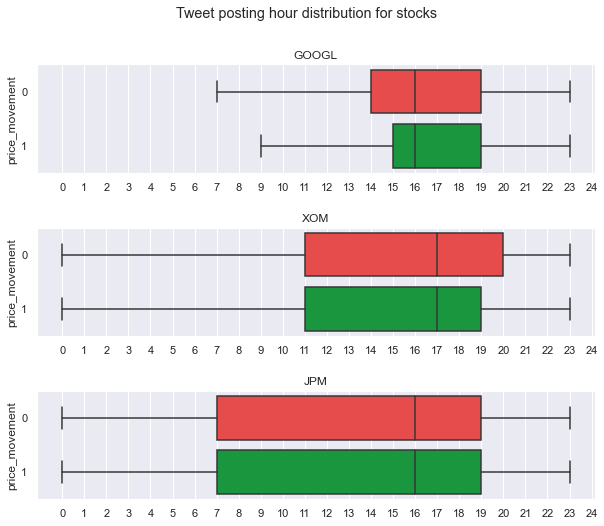

In [25]:
sns.set(rc={'figure.figsize':(10, 8)})
fig, ax = plt.subplots(3,1, sharex=True)
fig.suptitle('Tweet posting hour distribution for stocks')

for i, stock in enumerate(stocks):
    sns.boxplot(data=stocks_merged[stocks_merged.stock == stock], x='hour', y='price_movement', \
                orient='h', showfliers=False, palette=['#FF3333','#05AB37'], ax=ax[i])
    ax[i].title.set_text(stock)
    ax[i].set_xticks(np.arange(0,25))
    ax[i].xaxis.set_tick_params(labelbottom=True)
    ax[i].set_xlabel(None)

plt.subplots_adjust(hspace=0.5)  
plt.show();

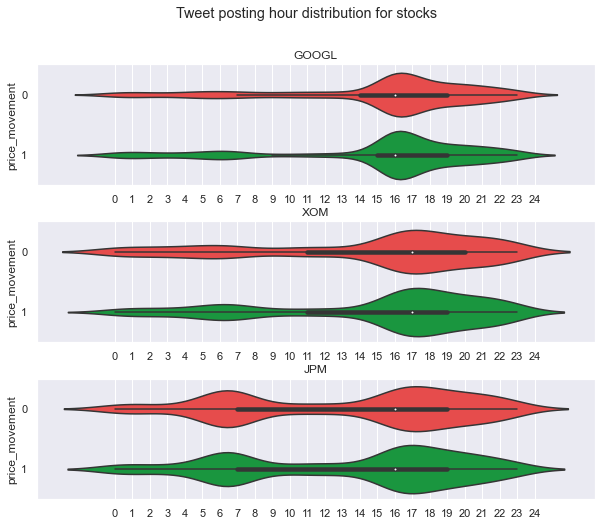

In [26]:
sns.set(rc={'figure.figsize':(10, 8)})
fig, ax = plt.subplots(3,1, sharex=True)
fig.suptitle('Tweet posting hour distribution for stocks')

for i, stock in enumerate(stocks):
    sns.violinplot(data=stocks_merged[stocks_merged.stock == stock], x='hour', y='price_movement', \
                orient='h', showfliers=False, palette=['#FF3333','#05AB37'], ax=ax[i])
    ax[i].title.set_text(stock)
    ax[i].set_xticks(np.arange(0,25))
    ax[i].xaxis.set_tick_params(labelbottom=True)
    ax[i].set_xlabel(None)

plt.subplots_adjust(hspace=0.3)  
plt.show();

#### minutes

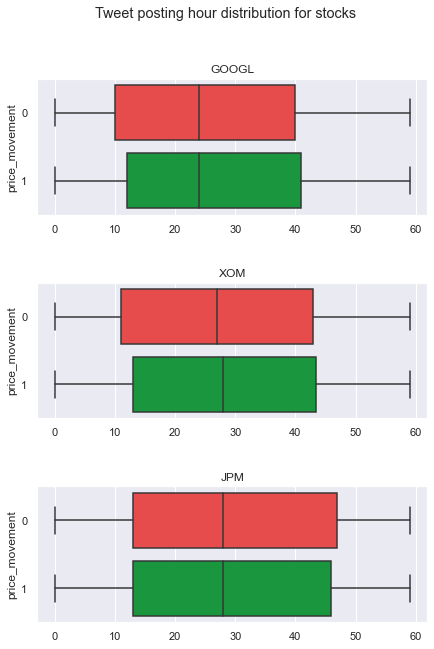

In [27]:
sns.set(rc={'figure.figsize':(7, 10)})
fig, ax = plt.subplots(3,1, sharex=True)
fig.suptitle('Tweet posting hour distribution for stocks')

for i, stock in enumerate(stocks):
    sns.boxplot(data=stocks_merged[stocks_merged.stock == stock], x='minutes', y='price_movement', \
                orient='h', showfliers=False, palette=['#FF3333','#05AB37'], ax=ax[i])
    ax[i].title.set_text(stock)
    ax[i].set_xticks(np.arange(0,61,10))
    ax[i].xaxis.set_tick_params(labelbottom=True)
    ax[i].set_xlabel(None)

plt.subplots_adjust(hspace=0.5)  
plt.show();

#### dayofweek

In [130]:
def get_days_of_week(df):
    
    dow_df = pd.DataFrame(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], columns=['dayofweek'])
    dow_df['price_up_count'] = df[df['price_movement'] == 1].\
                            groupby('dayofweek').count()['likeCount'].sort_index().values
    dow_df['price_down_count'] = df[df['price_movement'] == 0].\
                            groupby('dayofweek').count()['likeCount'].sort_index().values
    #NEW
    dow_df['total_tweets'] = dow_df['price_up_count'] + dow_df['price_down_count']
    dow_df['price_up_perc'] = round(dow_df['price_up_count'] / dow_df['total_tweets'],2)
    dow_df['price_down_perc'] = round(dow_df['price_down_count'] / dow_df['total_tweets'],2)
    
    return dow_df

In [131]:
googl_dow_df = get_days_of_week(stocks_merged[stocks_merged['stock'] == 'GOOGL'])
xom_dow_df = get_days_of_week(stocks_merged[stocks_merged['stock'] == 'XOM'])
jpm_dow_df = get_days_of_week(stocks_merged[stocks_merged['stock'] == 'JPM'])

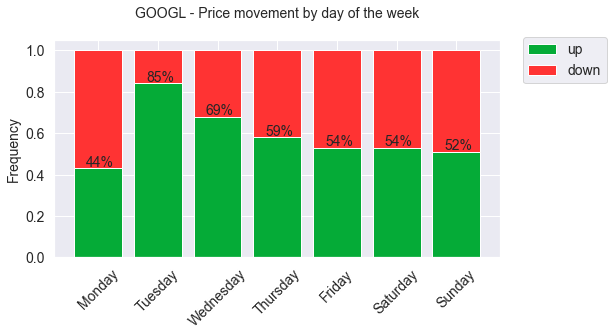

In [203]:
plt.figure(figsize=(8,4))
plt.bar(googl_dow_df['dayofweek'], googl_dow_df['price_up_perc'], color='#05AB37', label='up')
plt.bar(googl_dow_df['dayofweek'], googl_dow_df['price_down_perc'], bottom=googl_dow_df['price_up_perc'], color='#FF3333', label='down')
plt.ylabel('Frequency', fontsize=14)
plt.yticks(fontsize=14)
plt.title('GOOGL - Price movement by day of the week\n', fontsize=14)
plt.xticks(fontsize=14, rotation=45)
plt.legend(loc=(1.05, 0.8), fontsize=14)

# Annotate percentages up
for i, row in enumerate(googl_dow_df.values):
    x = i-0.2
    y = row[4]+0.01
    plt.text(x,y, str(round(y*100))+'%', fontsize=14);

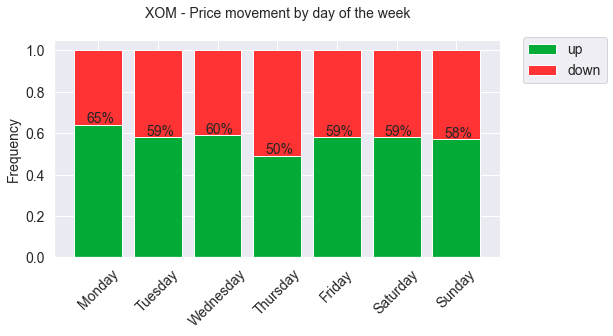

In [201]:
plt.figure(figsize=(8,4))
plt.bar(xom_dow_df['dayofweek'], xom_dow_df['price_up_perc'], color='#05AB37', label='up')
plt.bar(xom_dow_df['dayofweek'], xom_dow_df['price_down_perc'], bottom=xom_dow_df['price_up_perc'], color='#FF3333', label='down')
plt.ylabel('Frequency', fontsize=14)
plt.yticks(fontsize=14)
plt.title('XOM - Price movement by day of the week\n', fontsize=14)
plt.xticks(fontsize=14, rotation=45)
plt.legend(loc=(1.05, 0.8), fontsize=14)

# Annotate percentages up
for i, row in enumerate(xom_dow_df.values):
    x = i-0.2
    y = row[4]+0.01
    plt.text(x,y, str(round(y*100))+'%', fontsize=14);

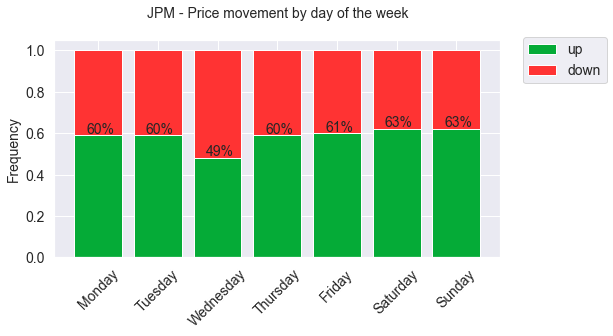

In [204]:
plt.figure(figsize=(8,4))
plt.bar(jpm_dow_df['dayofweek'], jpm_dow_df['price_up_perc'], color='#05AB37', label='up')
plt.bar(jpm_dow_df['dayofweek'], jpm_dow_df['price_down_perc'], bottom=jpm_dow_df['price_up_perc'], color='#FF3333', label='down')
plt.ylabel('Frequency', fontsize=14)
plt.yticks(fontsize=14)
plt.title('JPM - Price movement by day of the week\n', fontsize=14)
plt.xticks(fontsize=14, rotation=45)
plt.legend(loc=(1.05, 0.8), fontsize=14)

# Annotate percentages up
for i, row in enumerate(jpm_dow_df.values):
    x = i-0.2
    y = row[4]+0.01
    plt.text(x,y, str(round(y*100))+'%', fontsize=14);

#### Number of hashtags and mentions

We won't do analysis on hashtags and mentions, since the majority of the tweets in our dataset don't have them. Below you can see the percentage breakdown.

In [34]:
stocks_merged.number_hashtags.value_counts(normalize=True).head()

0    0.808354
1    0.095731
2    0.042690
3    0.024683
4    0.007779
Name: number_hashtags, dtype: float64

In [35]:
stocks_merged.number_mentions.value_counts(normalize=True).head()

0    0.702272
1    0.212838
2    0.052735
3    0.015496
4    0.007227
Name: number_mentions, dtype: float64

#### text length

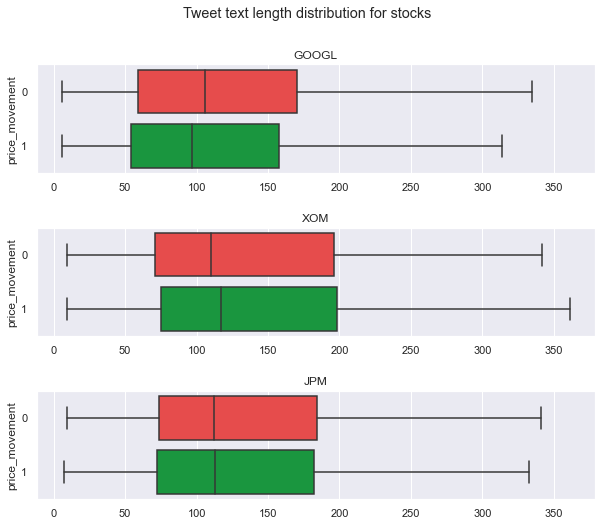

In [36]:
sns.set(rc={'figure.figsize':(10, 8)})
fig, ax = plt.subplots(3,1, sharex=True)
fig.suptitle('Tweet text length distribution for stocks')

for i, stock in enumerate(stocks):
    sns.boxplot(data=stocks_merged[stocks_merged.stock == stock], x='text_length', y='price_movement', \
                orient='h', showfliers=False, palette=['#FF3333','#05AB37'], ax=ax[i])
    ax[i].title.set_text(stock)
    ax[i].xaxis.set_tick_params(labelbottom=True)
    ax[i].set_xlabel(None)

plt.subplots_adjust(hspace=0.5)  
plt.show();

#### sentiment label

In [37]:
def get_sentiment_df(df):
    
    sentiment_df = pd.DataFrame([0, 1], columns=['price_movement'])
    
    sentiment_df['negative'] = df[df['sentiment_label'] == 'negative'].groupby('price_movement').count()['likeCount']
    sentiment_df['neutral'] = df[df['sentiment_label'] == 'neutral'].groupby('price_movement').count()['likeCount']         
    sentiment_df['positive'] = df[df['sentiment_label'] == 'positive'].groupby('price_movement').count()['likeCount']
    
    #Getting percentages
    total = sentiment_df['negative'] + sentiment_df['neutral'] + sentiment_df['positive']
    sentiment_df['negative_perc'] = round(sentiment_df['negative'] / total,2)
    sentiment_df['neutral_perc'] = round(sentiment_df['neutral'] / total,2)
    sentiment_df['positive_perc'] = round(sentiment_df['positive'] / total,2)
    
    return sentiment_df

In [38]:
googl_sentiment_df = get_sentiment_df(stocks_merged[stocks_merged['stock'] == 'GOOGL'])
xom_sentiment_df = get_sentiment_df(stocks_merged[stocks_merged['stock'] == 'XOM'])
jpm_sentiment_df = get_sentiment_df(stocks_merged[stocks_merged['stock'] == 'JPM'])

In [39]:
googl_sentiment_df[['negative_perc','neutral_perc','positive_perc']]

,negative_perc,neutral_perc,positive_perc
0,0.20,0.54,0.26
1,0.11,0.57,0.32


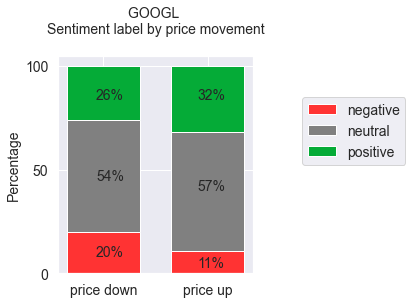

In [206]:
df=googl_sentiment_df.copy()

sns.set(rc={'figure.figsize':(3.5, 4)})
plt.bar(df['price_movement'], df['negative_perc'], color='#FF3333', label='negative', width=0.7)
plt.bar(df['price_movement'], df['neutral_perc'], color='grey', label='neutral', bottom=df['negative_perc'], width=0.7)
plt.bar(df['price_movement'], df['positive_perc'], color='#05AB37', label='positive',\
                bottom=df['negative_perc']+df['neutral_perc'], width=0.7)
plt.ylabel('Percentage', fontsize=14)
plt.title(f'GOOGL \nSentiment label by price movement\n', fontsize=14)
plt.xticks(ticks=[0,1], labels=['price down','price up'], fontsize=14)
plt.yticks(ticks=[0,0.5,1], labels=['0','50','100'], fontsize=14)

plt.text(-0.07, 0.08, '20%', fontsize=14)
plt.text(-0.07, .45, '54%', fontsize=14)
plt.text(-0.07, .84, '26%', fontsize=14)

plt.text(0.9, 0.03, '11%', fontsize=14)
plt.text(0.9, .40, '57%', fontsize=14)
plt.text(0.9, .84, '32%', fontsize=14)

plt.legend(loc=(1.25,0.5), fontsize=14);

In [41]:
xom_sentiment_df[['negative_perc','neutral_perc','positive_perc']]

,negative_perc,neutral_perc,positive_perc
0,0.18,0.58,0.23
1,0.18,0.58,0.23


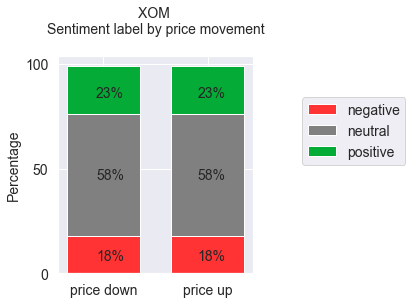

In [207]:
df=xom_sentiment_df.copy()

sns.set(rc={'figure.figsize':(3.5, 4)})
plt.bar(df['price_movement'], df['negative_perc'], color='#FF3333', label='negative', width=0.7)
plt.bar(df['price_movement'], df['neutral_perc'], color='grey', label='neutral', bottom=df['negative_perc'], width=0.7)
plt.bar(df['price_movement'], df['positive_perc'], color='#05AB37', label='positive',\
                bottom=df['negative_perc']+df['neutral_perc'], width=0.7)
plt.ylabel('Percentage', fontsize=14)
plt.title(f'XOM \nSentiment label by price movement\n', fontsize=14)
plt.xticks(ticks=[0,1], labels=['price down','price up'], fontsize=14)
plt.yticks(ticks=[0,0.5,1], labels=['0','50','100'], fontsize=14)

plt.text(-0.07, 0.06, '18%', fontsize=14)
plt.text(-0.07, .45, '58%', fontsize=14)
plt.text(-0.07, .84, '23%', fontsize=14)

plt.text(0.9, 0.06, '18%', fontsize=14)
plt.text(0.9, .45, '58%', fontsize=14)
plt.text(0.9, .84, '23%', fontsize=14)

plt.legend(loc=(1.25,0.5), fontsize=14);

In [43]:
jpm_sentiment_df[['negative_perc','neutral_perc','positive_perc']]

,negative_perc,neutral_perc,positive_perc
0,0.16,0.61,0.23
1,0.15,0.62,0.23


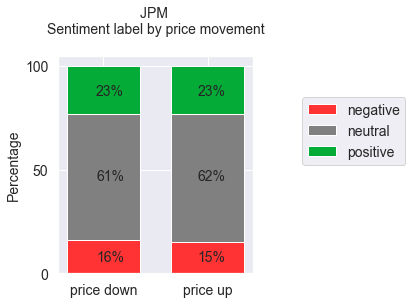

In [208]:
df=jpm_sentiment_df.copy()

sns.set(rc={'figure.figsize':(3.5, 4)})
plt.bar(df['price_movement'], df['negative_perc'], color='#FF3333', label='negative', width=0.7)
plt.bar(df['price_movement'], df['neutral_perc'], color='grey', label='neutral', bottom=df['negative_perc'], width=0.7)
plt.bar(df['price_movement'], df['positive_perc'], color='#05AB37', label='positive',\
                bottom=df['negative_perc']+df['neutral_perc'], width=0.7)
plt.ylabel('Percentage', fontsize=14)
plt.title(f'JPM \nSentiment label by price movement\n', fontsize=14)
plt.xticks(ticks=[0,1], labels=['price down','price up'], fontsize=14)
plt.yticks(ticks=[0,0.5,1], labels=['0','50','100'], fontsize=14)

plt.text(-0.07, 0.06, '16%', fontsize=14)
plt.text(-0.07, .45, '61%', fontsize=14)
plt.text(-0.07, .86, '23%', fontsize=14)

plt.text(0.9, 0.06, '15%', fontsize=14)
plt.text(0.9, .45, '62%', fontsize=14)
plt.text(0.9, .86, '23%', fontsize=14)

plt.legend(loc=(1.25,0.5), fontsize=14);

#### sentiment score

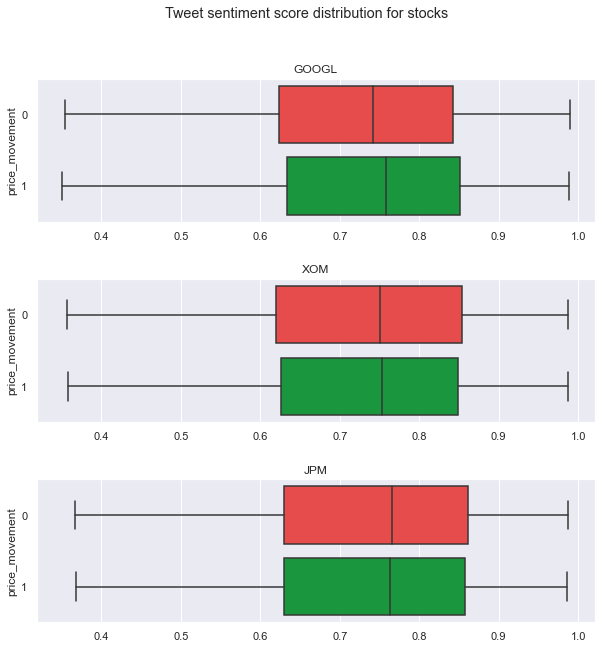

In [45]:
sns.set(rc={'figure.figsize':(10, 10)})
fig, ax = plt.subplots(3,1, sharex=True)
fig.suptitle('Tweet sentiment score distribution for stocks')

for i, stock in enumerate(stocks):
    sns.boxplot(data=stocks_merged[stocks_merged.stock == stock], x='sentiment_score', y='price_movement', \
                orient='h', showfliers=False, palette=['#FF3333','#05AB37'], ax=ax[i])
    ax[i].title.set_text(stock)
    ax[i].xaxis.set_tick_params(labelbottom=True)
    ax[i].set_xlabel(None)

plt.subplots_adjust(hspace=0.4)  
plt.show();

### Correlation heatmap - numerical

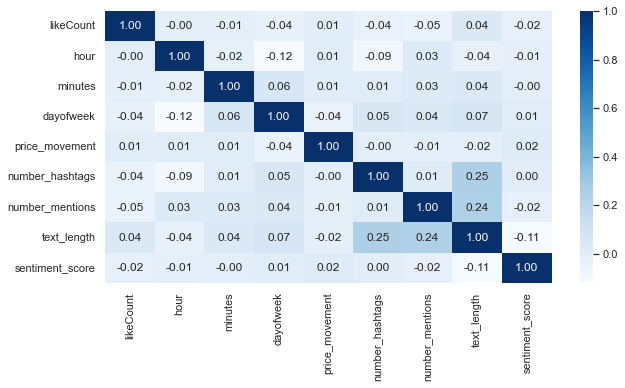

In [46]:
plt.figure(figsize=(10,5))
sns.heatmap(stocks_merged.corr(), cmap='Blues', annot=True, fmt='.2f');

### Correlation heatmp - categorical

Since we can't get correlation between categorical variables, we'll use this function for Cramers V

In [47]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [48]:
cat_cols.remove('date_x')

In [49]:
# Creating an extended category list and adding "price_movement" to see also correlation to target variable
cat_cols_corr = cat_cols
cat_cols_corr.append(('price_movement'))
print(cat_cols_corr)

['username', 'stock', 'sentiment_label', 'price_movement']


In [50]:
# Creating dataframe to capture correlation values from categorical features
corr_cat = pd.DataFrame(index=cat_cols_corr, columns=cat_cols_corr)

In [51]:
# Cycling thru categorical features to obtain correlation using Cramers V function
for cat in corr_cat.index:
    for col in corr_cat.columns:
        corr_cat.loc[cat, col] = cramers_v(stocks_merged[cat], stocks_merged[col])
        
# Converting values from string to float
corr_cat = corr_cat.astype(float)

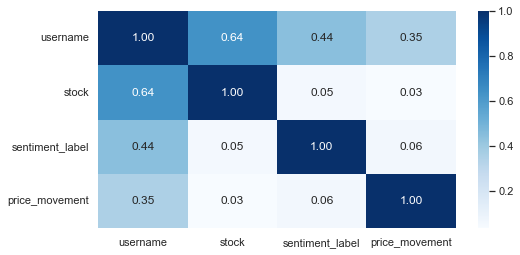

In [52]:
# plotting correlation heatmap for categorical variables
plt.figure(figsize = (8, 4))
sns.heatmap(corr_cat, cmap='Blues', annot=True, fmt='.2f');

## EDA for tweets text

Let's segment the tweets by stock so it's easier to reference them later.

In [53]:
googl_text = stocks_text[stocks_text['stock'] == 'GOOGL']
xom_text = stocks_text[stocks_text['stock'] == 'XOM']
jpm_text = stocks_text[stocks_text['stock'] == 'JPM']

# These will be a variation used to display tweets examples showing username or date
googl_text_username_date = stocks_text_username_date[stocks_text_username_date['stock'] == 'GOOGL']
xom_text_username_date = stocks_text_username_date[stocks_text_username_date['stock'] == 'XOM']
jpm_text_username_date = stocks_text_username_date[stocks_text_username_date['stock'] == 'JPM']

Now we'll get word frequencies for each stock, we'll try this for unigrams and bigrams to see how it looks. We'll define a function to get the ngrams frequency.

In [54]:
def get_word_ngrams(df, min_df, ngrams):    
    
    vectorizer_freq = CountVectorizer(min_df=min_df, ngram_range=ngrams, stop_words='english')

    X = vectorizer_freq.fit_transform(df['lem_text'])
    y = df['price_movement']

    frequencies = X.toarray().sum(axis=0)

    freq_df = pd.DataFrame(frequencies, index=vectorizer_freq.get_feature_names_out(), columns=['word_frequency'])\
            .sort_values('word_frequency', ascending=False)
    
    return freq_df

Getting unigrams and bigrams for the 3 stocks using our function

In [55]:
# Unigrams
googl_unigrams_freq = get_word_ngrams(googl_text, 50, (1,1))
xom_unigrams_freq = get_word_ngrams(xom_text, 50, (1,1))
jpm_unigrams_freq = get_word_ngrams(jpm_text, 50, (1,1))

# Bigrams
googl_bigrams_freq = get_word_ngrams(googl_text, 50, (2,2))
xom_bigrams_freq = get_word_ngrams(xom_text, 50, (2,2))
jpm_bigrams_freq = get_word_ngrams(jpm_text, 50, (2,2))

Defining a quick function to plot the top 10 unigrams (words) and bigrams.

In [56]:
def plot_ngrams(unigrams, bigrams, stock):
    sns.set(rc={'figure.figsize':(16, 5)})
    fig, ax = plt.subplots(1, 2)
    fig.suptitle(f'{stock} - Word Frequencies\n')

    unigrams[1:11].plot(kind='bar', ax=ax[0])  # excluding the first record since it will be our ticker
    ax[0].set_title('Top 10 words (excluding ticker)', fontdict={'fontsize':14})
    ax[0].xaxis.set_tick_params(labelrotation=75)
    ax[0].tick_params(axis='both', labelsize=14)
    ax[0].get_legend().remove()

    bigrams[:10].plot(kind='bar', ax=ax[1])
    ax[1].set_title('Top 10 bigrams', fontdict={'fontsize':14})
    ax[1].xaxis.set_tick_params(labelrotation=75)
    ax[1].tick_params(axis='both', labelsize=14)
    ax[1].get_legend().remove()

    plt.show();

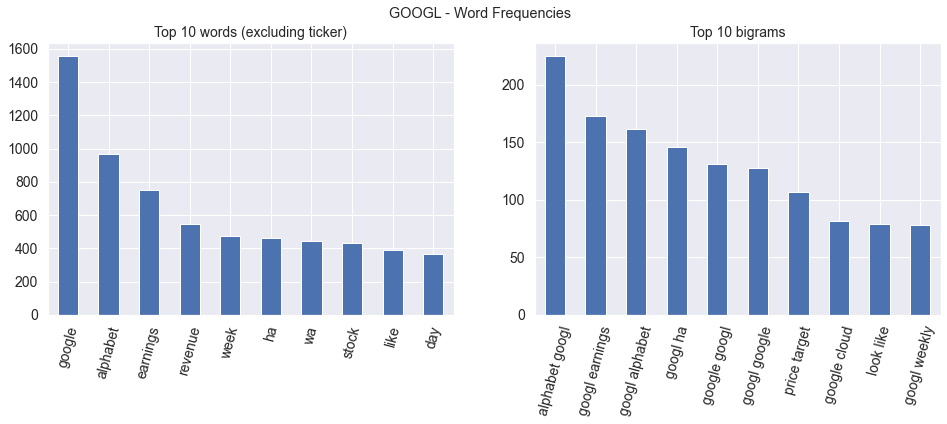

In [57]:
plot_ngrams(googl_unigrams_freq, googl_bigrams_freq, 'GOOGL')

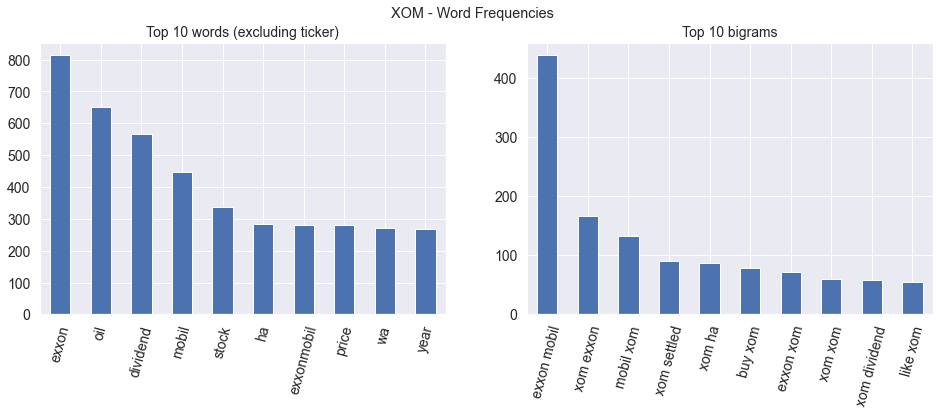

In [58]:
plot_ngrams(xom_unigrams_freq, xom_bigrams_freq, 'XOM')

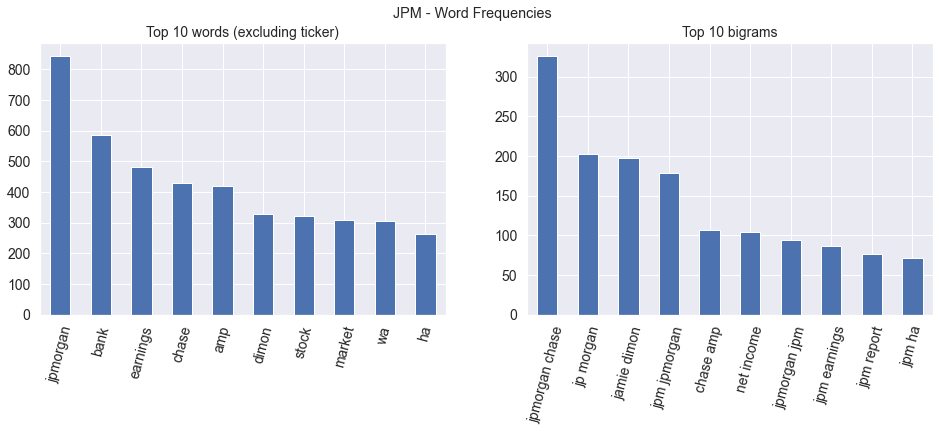

In [59]:
plot_ngrams(jpm_unigrams_freq, jpm_bigrams_freq, 'JPM')

Defining function to pull tweets with a specific word to analyze

In [60]:
def get_word_tweets(word, df):
    
    tweets_list = []
    price_list = []
    
    for tweet in df.iterrows():
        if word in tweet[1][1]:
            tweets_list.append(tweet[1][1])
            price_list.append(tweet[1][2])
    
    new_df = pd.DataFrame({'lem_text':tweets_list, 'price_movement':price_list})
    
    return new_df

Defining another function with the following purposes:
- Vectorize all our tweets using CountVectorizer based on a minimum document frequency that's passed as a function parameter
- It creates a basic Multinomial Naive Bayes model and calculates probability of each word in predicting an up movement
- Build a dataframe of good words (higher probability) and bad words (lower probability), you can adjust the number of words you want by passing as the number_words parameter
- Add to the dataframes the frequency of the word, as well as percentage that it was found in up or down movement.

In [61]:
def get_words(df, number_words, min_df=50):
    
    vectorizer = CountVectorizer(min_df=min_df, ngram_range=(1,1), stop_words='english')

    X = vectorizer.fit_transform(df['lem_text'])
    y = df['price_movement']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Training basic model
    nb_clf = MultinomialNB()
    nb_clf.fit(X_train, y_train)

    words = np.array(vectorizer.get_feature_names_out())

    # Predicting probability for each word
    x = np.eye(X_test.shape[1])
    probs = nb_clf.predict_proba(x)[:, 0]
    ind = np.argsort(probs)

    # Subsetting only a specific number of words we want
    good_words = words[ind[:number_words]]
    bad_words = words[ind[-number_words:]]

    good_prob = probs[ind[:number_words]]
    bad_prob = probs[ind[-number_words:]]
    
    
    # Creating good words dataframe
    good_words_df = pd.DataFrame(columns=['word','probability'])

    for i in range(number_words):
        good_words_df.loc[i,'word'] = good_words[i]
        good_words_df.loc[i,'probability'] = round(1 - good_prob[i],2)
    
    for i, word in enumerate(good_words_df.iterrows()):
        tweets = get_word_tweets(word[1][0], df)
        good_words_df.loc[i,'word_frequency'] = tweets['price_movement'].count()
        good_words_df.loc[i,'perc_price_up'] = round(tweets[tweets['price_movement'] == 1]['price_movement'].count() / good_words_df.loc[i,'word_frequency'],2)
        good_words_df.loc[i,'perc_price_down'] = round(tweets[tweets['price_movement'] == 0]['price_movement'].count() / good_words_df.loc[i,'word_frequency'],2)

    good_words_df['word_frequency'] = good_words_df['word_frequency'].astype('int')
    
    
    # Creating bad words dataframe
    bad_words_df = pd.DataFrame(columns=['word','probability'])

    for i in range(number_words-1,-1,-1):
        bad_words_df.loc[i,'word'] = bad_words[i]
        bad_words_df.loc[i,'probability'] = round(1 - bad_prob[i],2)
    
    bad_words_df = bad_words_df.reset_index(drop=True)
    
    for i, word in enumerate(bad_words_df.iterrows()):
        tweets = get_word_tweets(word[1][0],df)
        bad_words_df.loc[i,'word_frequency'] = tweets['price_movement'].count()
        bad_words_df.loc[i,'perc_price_up'] = round(tweets[tweets['price_movement'] == 1]['price_movement'].count()/tweets['price_movement'].count(),2)
        bad_words_df.loc[i,'perc_price_down'] = round(tweets[tweets['price_movement'] == 0]['price_movement'].count()/tweets['price_movement'].count(),2)
    
    bad_words_df['word_frequency'] = bad_words_df['word_frequency'].astype('int')
    
    
    return good_words_df, bad_words_df

Now we'll use our functions to pull the good and bad words for predicting up movement for each stock. We'll have to play with the min_df parameter to see which one works best for each stock.

### GOOGL

In [62]:
googl_good_words, googl_bad_words = get_words(googl_text, 10, 40)

In [63]:
googl_good_words

,word,probability,word_frequency,perc_price_up,perc_price_down
0,_fire_,0.96,45,0.87,0.13
1,margin,0.9,65,0.78,0.22
2,elliottwave,0.89,77,0.86,0.14
3,pullback,0.88,48,0.73,0.27
4,weekend,0.86,43,0.74,0.26
5,_rocket_,0.85,58,0.88,0.12
6,march,0.84,51,0.80,0.20
7,box,0.83,62,0.77,0.23
8,content,0.83,44,0.77,0.23
9,rev,0.81,725,0.63,0.37


In [64]:
googl_bad_words

,word,probability,word_frequency,perc_price_up,perc_price_down
0,reuterstv,0.15,42,0.14,0.86
1,miss,0.2,145,0.30,0.70
2,live,0.29,88,0.45,0.55
3,wait,0.36,69,0.51,0.49
4,covid,0.36,46,0.39,0.61
5,user,0.37,64,0.45,0.55
6,inside,0.37,108,0.44,0.56
7,bull,0.39,209,0.66,0.34
8,drop,0.4,93,0.43,0.57
9,cnbc,0.42,71,0.49,0.51


Let's analyze some sample tweets for the top 3 good and bad words

In [65]:
# Increasing column width to be able to read tweets better
pd.set_option('display.max_colwidth',250)

# Disabling text formatting so it's easier to read (example: no bold, italic, etc)
pd.set_option('display.html.use_mathjax', False)

#### GOOGL - Good words

We'll define a similar function as before, but this time it will include username and date.

In [66]:
def get_word_tweets_with_username(word, df):
    
    username_list=[]
    date_list = []
    tweets_list = []
    price_list = []
    
    for tweet in df.iterrows():
        if word in tweet[1][3]:
            username_list.append(tweet[1][1])
            date_list.append(tweet[1][2])
            tweets_list.append(tweet[1][3])
            price_list.append(tweet[1][4])
    
    new_df = pd.DataFrame({'username':username_list,'date': date_list,'lem_text':tweets_list, 'price_movement':price_list})
    
    return new_df

In [67]:
fire = get_word_tweets_with_username('_fire_',googl_text_username_date)
print(fire.price_movement.value_counts())
fire[fire.price_movement == 1].sample(5)

1    39
0     6
Name: price_movement, dtype: int64


,username,date,lem_text,price_movement
27,HedgeyeComm,2021-07-27,$googl guess the quarter wa good enough youtube $b v $b consensus yoy search amp other $b v $b yoy _fire_ _fire_ _fire_ _fire_ $b fcf v $b consensus $ eps v $,1
10,gannonbreslin,2020-04-28,$googl setting the tone let’s keep this momentum _fire_,1
4,gualestrit,2019-07-25,intel ingresos $m beat $m est _fire_ eps $ beat $ est $googl afterhours,1
25,BigBullCap,2021-07-27,$googl monster _fire_,1
40,HedgeyeComm,2021-04-27,that youtube growth rate _fire_ $googl,1


In [68]:
margin = get_word_tweets_with_username('margin',googl_text_username_date)
print(margin.price_movement.value_counts())
margin[margin.price_movement == 1].sample(5)

1    51
0    14
Name: price_movement, dtype: int64


,username,date,lem_text,price_movement
24,froth123,2021-12-15,@irbezek that’s a stretch but $googl is the best stock in the market insane profit margin,1
23,froth123,2021-12-15,@irbezek that’s a stretch but $googl is the best stock in the market insane profit margin,1
1,GS_CapSF,2018-07-23,$googl ebit margin peaked two year ago yoy incremental margin negative for qtrs httpstcokeusxttl,1
31,financialjuice,2021-07-27,alphabet inc $googl q earnings eps $ est $ rev $b est $b other bet rev $m est $m oper income $b est $b oper income $b est $b oper margin est google cloud rev $b est $b,1
17,BNNBloomberg,2020-04-28,#breaking alphabet q operating margin v yearoveryear $googl,1


In [69]:
elliottwave = get_word_tweets_with_username('elliottwave',googl_text_username_date)
print(elliottwave.price_movement.value_counts())
elliottwave[elliottwave.price_movement == 1].sample(5)

1    66
0    11
Name: price_movement, dtype: int64


,username,date,lem_text,price_movement
75,ElliottForecast,2021-03-10,$googl is favoured to extend a little lower before moving higher but we dont like to sell this name we like to look for the extreme where buyer may enter a long a price remain above we like higher price extension #elliottwave #trading #stocks,1
22,ElliottForecast,2021-11-12,$googl hr view from weekend update presented to member at httpstcoorfdlepb #elliottwave #trading #google httpstcopqfwymcbl,1
18,EWAnalysis,2021-11-29,$googl hr view from midday update the stock reached the blue box area and gave u a good a buying opportunity #elliottwave #trading #google find more at httpstcoqmivjbqer httpstcocjjcufb,1
37,ElliottForecast,2021-11-07,$googl hr update from weekend presented from to member at httpstcoorfdlepb #elliottwave #trading #google httpstcowuuhysl,1
52,hassaansh,2021-10-12,$googl hr view from premarket update extends lower a expected #elliottwave #trading #google httpstcowuaqqug,1


In [70]:
elliottwave['username'].value_counts(normalize=True)

ElliottForecast    0.688312
hassaansh          0.129870
bhattidaud         0.051948
EWAnalysis         0.038961
EMECapital1        0.025974
elliottwavenew     0.025974
cmellon1976        0.025974
PBratbyOfficial    0.012987
Name: username, dtype: float64

#### GOOGL - Bad words

In [71]:
reuterstv = get_word_tweets_with_username('reuterstv',googl_text_username_date)
print(reuterstv.price_movement.value_counts())
reuterstv[reuterstv.price_movement == 0].sample(5)

0    36
1     6
Name: price_movement, dtype: int64


,username,date,lem_text,price_movement
13,Reuters,2019-05-12,facebook reject cofounder call for breakup httpstcollbxohkzm via the @reuterstv tech playlist see more in this week tech playlist httpstcollbxohkzm via @reuterstv $googl httpstcocewccytosd,0
29,Reuters,2019-05-10,facebook reject cofounder chris hughes call for breakup httpstcollbxohnjc via the @reuterstv tech playlist $googl httpstcotuuimwxtux,0
25,ReutersBiz,2019-05-11,watch facebook reject cofounder call for breakup senator urge u antitrust probe more in this week tech playlist httpstcoutuqeaoej via @reuterstv $googl httpstcovqnzdue,0
17,Reuters,2019-05-11,facebook reject cofounder chris hughes call for breakupmore in this week tech playlist httpstcollbxohnjc via @reuterstv $googl httpstcoizdvg,0
30,Reuters,2019-05-10,google will introduce incognito mode on it map app later this year more from the io developer conference httpstcollbxohnjc via the @reuterstv tech playlist $googl httpstcobefdvraucx,0


In [72]:
reuterstv[['date', 'price_movement','lem_text']].groupby(['price_movement','date']).count()

lem_text
price_movement date                
0              2019-04-30         3
               2019-05-10        10
               2019-05-11        11
               2019-05-12         9
               2019-05-19         1
               2019-05-20         2
1              2018-07-24         1
               2018-09-26         1
               2018-12-17         2
               2019-04-01         2

In [73]:
reuterstv[reuterstv.date == '2019-05-12']

,username,date,lem_text,price_movement
7,ReutersBiz,2019-05-12,watch google will introduce incognito mode on it map app later this year see more in this week tech playlist httpstcoutuqest via @reuterstv $googl httpstcowllbkudcr,0
8,Reuters,2019-05-12,facebook reject cofounder chris hughes call for breakup see more in this week tech playlist httpstcollbxohnjc via @reuterstv $googl httpstcowrjbig,0
9,Reuters,2019-05-12,google will introduce incognito mode on it map app later this year see more in this week tech playlist httpstcollbxohkzm via @reuterstv $googl httpstcogaaelyulie,0
10,Reuters,2019-05-12,facebook reject cofounder call to break up the social medium giant into three separate company see more in this week tech playlist httpstcollbxohkzm via @reuterstv $googl httpstcoxfznodd,0
11,ReutersBiz,2019-05-12,watch google will allow user to choose how long the company keep their data see more in this week tech playlist httpstcoutuqeaoej via @reuterstv $googl httpstcognbws,0
12,Reuters,2019-05-12,google will allow user to choose how long the company keep their data see more in this week tech playlist httpstcollbxohkzm via @reuterstv $googl httpstcoxcxxqxoax,0
13,Reuters,2019-05-12,facebook reject cofounder call for breakup httpstcollbxohkzm via the @reuterstv tech playlist see more in this week tech playlist httpstcollbxohkzm via @reuterstv $googl httpstcocewccytosd,0
14,Reuters,2019-05-12,facebook reject cofounder call for breakup senator urge u antitrust probe see more in this week tech playlist httpstcollbxohkzm via @reuterstv $googl httpstcoiufcgdbjfj,0
15,Reuters,2019-05-12,google is trying hard to convince consumer that it safe to trust them an issue it put front and center at it developer conference see more in this week tech playlist httpstcollbxohkzm via @reuterstv $googl httpstcolqyofieyzh,0


In [74]:
miss = get_word_tweets_with_username('miss',googl_text_username_date)
print(miss.price_movement.value_counts())
miss[miss.price_movement == 0].sample(5)

0    101
1     44
Name: price_movement, dtype: int64


,username,date,lem_text,price_movement
12,ArjunKharpal,2018-04-24,here my colleague @jillianiles full wrap of alphabet earnings from yesterday in case you missed it $googl httpstcoqlzmpdxfj,0
73,L0gg0l,2019-04-29,$googl top and bottom line miss incl item,0
11,Street_Insider,2018-07-18,european commission fine google $googl eur billion for illegal practice regarding android mobile device httpstcocpuwsljaud,0
41,OptionsMike,2019-10-28,$googl look like eps miss rev beat,0
51,TradeWithDrJohn,2019-04-29,thank you for watching everyone great discussion on winning trade and a look at the pennant on $googl and how to get freebie into earnings in case you missed it here is the recording httpstcooytngdeo,0


In [75]:
live = get_word_tweets_with_username('live',googl_text_username_date)
print(live.price_movement.value_counts())
live[live.price_movement == 0].sample(5)

0    48
1    40
Name: price_movement, dtype: int64


,username,date,lem_text,price_movement
18,Finding_Moats,2019-11-10,“a year and a half ago i had no idea who logan paul and ksi were” said adam smith head of boxing at sky sport more than a million fan paid £ to watch the official live stream on youtube with many more accessing it via illegal stream $googl httpst...,0
73,chamesa87,2021-08-17,@borrowedideas also wondering why someone with so much insider knowledge like sridhar would actively try to compete with $googl with a product that isnt free surely he know how strong of moat google ha and is well versed disruption theory is he j...,0
72,chamesa87,2021-08-17,@borrowedideas also wondering why someone with so much insider knowledge like sridhar would actively try to compete with $googl with a product that isnt free surely he know how strong of moat google ha and is well versed disruption theory is he j...,0
38,TheStreet,2019-04-29,stock now dow up nasdaq up sampp up follow our #stockoftheday $googl live earnings blog here httpstcojkqzepwsy,0
70,MatthewKeysLive,2021-09-16,google want to incorporate free adsupported streaming television channel into the live tab on google tv @jank say httpstcotiasngrxi in many way it trying to catch up to amazon and roku which already do this $googl,0


### XOM

In [76]:
xom_good_words, xom_bad_words = get_words(xom_text, 10, 40)

In [77]:
xom_good_words

,word,probability,word_frequency,perc_price_up,perc_price_down
0,portfolio,0.78,48,0.73,0.27
1,member,0.77,72,0.74,0.26
2,debt,0.77,56,0.71,0.29
3,pay,0.76,137,0.64,0.36
4,say,0.74,135,0.73,0.27
5,bullish,0.74,110,0.74,0.26
6,end,0.73,817,0.57,0.43
7,work,0.72,83,0.63,0.37
8,dont,0.71,56,0.73,0.27
9,investor,0.71,133,0.66,0.34


In [78]:
xom_bad_words

,word,probability,word_frequency,perc_price_up,perc_price_down
0,break,0.34,131,0.58,0.42
1,really,0.35,47,0.38,0.62
2,view,0.35,87,0.49,0.51
3,sector,0.4,78,0.40,0.60
4,interesting,0.41,48,0.40,0.60
5,report,0.42,66,0.52,0.48
6,stockmarket,0.43,67,0.51,0.49
7,higher,0.44,91,0.43,0.57
8,elliottwave,0.44,66,0.48,0.52
9,engine,0.45,80,0.60,0.40


#### XOM - Good words

In [79]:
portfolio = get_word_tweets_with_username('portfolio', xom_text_username_date)
print(portfolio.price_movement.value_counts())
portfolio[portfolio.price_movement == 1].sample(5)

1    35
0    13
Name: price_movement, dtype: int64


,username,date,lem_text,price_movement
31,cm_energyintel,2021-04-28,@qcontrarian oh for sure more just noting the contrast given timing the more applicable comparison for sure is $xom which ha had to scrap dividend growth a a medium term plan to sort out it balance sheet and reset it portfolio,1
7,energyintel,2020-11-13,a struggling exxon mobil review it global operation country by country it appears that a longexpected reckoning for it massive u dry #gas portfolio will finally come to a head read the full story free httpstcohuppzqvtwu $xom #shale,1
3,StockScoops,2019-03-29,exxon ha quietly assembled vast portfolio of new resource httpstcofxorxer $xom #stocks #stockmarket,1
15,ryan_engh,2020-05-15,@wealthbabylon great analysis will definitely consider adding some $xom to my portfolio next week i’ve been slowly adding position of aristocrat recently so this is awesome to read _thumbs_up:_medium-light_skin_tone_,1
12,Living_Swelll,2020-09-14,@trevorrrr $xom make up of my dividend portfolio the dividend _dollar_banknote_ are a major _key_ get money _yen_banknote_ buy income httpstcoijdrmdlcf,1


In [80]:
member = get_word_tweets_with_username('member', xom_text_username_date)
print(member.price_movement.value_counts())
member[member.price_movement == 1].sample(5)

1    53
0    19
Name: price_movement, dtype: int64


,username,date,lem_text,price_movement
68,ReenergizeXOM,2021-02-04,ceo who don’t welcome dissent try to pack the court”@jeffsonnenfeld via @harvardbiz #exxons board ha underperformed dramatically amp defied shareholder sentiment it hasnt earned the right to choose it own new member disc httpstcocxibcdv $xom,1
18,gamesblazer06,2021-08-21,moar #esg amp greenboondoggles republican sweep midterm in also long $xom on shortage amp long lines… growing up i remember oddeven license plate for gasoline are we going back there stay tuned… let’s see how hard they go on wind solar ev,1
70,ElliottForecast,2021-01-27,$xom right side is higher in medium term a long a price remain above the swing low further extension higher can take place here the h mid day view presented to member we like to trade extreme area and not the middle #elliottwave #trading #stoocks...,1
17,gamesblazer06,2021-10-13,regulation always favor big company at the expense of smaller guy by design… coz it affords more control see bank post gfc…competition can’t afford regs remember “too big too fail” guess who got bigger they want it that way $xom,1
39,WholeMarsBlog,2021-05-26,you may remember $xom urging investor to vote against the activist’s proposal “now is not the time to deviate from our strategy don’t be deceived by a month old hedge fundx engine # that want your company to pursue a vague and undefined plan” htt...,1


In [81]:
debt = get_word_tweets_with_username('debt', xom_text_username_date)
print(debt.price_movement.value_counts())
debt[debt.price_movement == 1].sample(5)

1    40
0    16
Name: price_movement, dtype: int64


,username,date,lem_text,price_movement
48,SleipnirPerkins,2021-03-23,@cmenergyintel funny $xom will have plenty of fcf to pay down debt and strengthen balance sheet going forward upgrade by qq,1
40,cm_energyintel,2021-04-30,exxon carry torch on major capital discipline q marked the first time in q that $xom could selffund capex and it dividend but the cash flow euphoria and work to pay down debt extended across the major my latest free httpstcopbwjunto #eft #oott,1
32,Natty_SMG,2021-10-04,@winstontrades run to ex div is going to interesting then…if leadership announces either stock buyback or raise divi this is going to be crazy $ before end of year is not unrealistic they are definitely crushing the debt which is the only stoppin...,1
4,eddiedonmez,2020-11-16,same a $xom “exxon need another $b to fund dividend next year mkm analyst” @chigrl this is based on $bbl major red flag when an entity raise debt to pay dividend,1
49,SleipnirPerkins,2021-03-23,@cmenergyintel funny $xom will have plenty of fcf to pay down debt and strengthen balance sheet going forward upgrade by qq,1


#### XOM - Bad words

In [82]:
break_ = get_word_tweets_with_username('break', xom_text_username_date)
print(break_.price_movement.value_counts())
break_[break_.price_movement == 0].sample(5)

1    76
0    55
Name: price_movement, dtype: int64


,username,date,lem_text,price_movement
0,MarkNewtonCMT,2018-10-03,$xom exxon mobil is just on the verge of exceeding the entire downtrend from four year ago #ibdpartner discussed on cnbc today why this stock looked attractive amp @marketsmith show the breakout attempt this week after prior retests expect move t...,0
71,_MrSqueeze,2021-08-15,$xom daily chart _beverage_box_ got a break down through this rising wedge here found support the first time at a key pivot but look like it going to retest it in the near future somewhere around my gray box could get a double bottom or a flush b...,0
16,TrendSpider,2020-12-07,$xom #xom nice impulse move after the balloon breakout last week httpstcourocdgmfr,0
83,narmacnetworth,2021-06-02,@pmack problem with adding here is it weighted on $xom which is currently breaking out i do think the inflation name take a big hit this month so your strike will be fine nonetheless,0
22,EnergyCredit1,2020-10-10,$xom for xto a trip down memory lane of xto proved reserve produced of purchase price recouped more year to hit fcf breakeven total xom cant cover it dividend sorry bad link last time httpstcozhinsfddx via @unhedgedapp,0


In [83]:
really = get_word_tweets_with_username('really', xom_text_username_date)
print(really.price_movement.value_counts())
really[really.price_movement == 0].sample(5)

0    29
1    18
Name: price_movement, dtype: int64


,username,date,lem_text,price_movement
30,tompaja,2021-07-26,@devilbebop really eager to see how energy stock behave after earnings $xom report on friday should give u an idea httpstcoesevvpv,0
5,arcady_s,2020-12-07,@andykarsner i couldn’t agree more having spent time with some of the other more progressive oil and gas major it’s become abundantly clear how far behind $xom really is,0
25,GasBuddyGuy,2021-08-30,source indicate that $xom in baton rouge is out of diesel completely and that allocation are ongoing for gasoline i really hope that the region see some diesel incoming,0
33,jmoneystonks,2021-05-16,working on this handle might need another week or so really like the setup and in a strong sector watching close @aottrades $xom httpstcomhkjff,0
27,Jake__Wujastyk,2021-08-08,$xom #xom still liking this one daily candle trading right at the volume shelf just need a close above to really get going target above $ swinghigh anchored vwap httpstconomvuktl,0


In [84]:
view = get_word_tweets_with_username('view', xom_text_username_date)
print(view.price_movement.value_counts())
view[view.price_movement == 0].sample(5)

0    44
1    43
Name: price_movement, dtype: int64


,username,date,lem_text,price_movement
40,Tickeron,2021-07-17,$xom enters a downtrend a momentum indicator dropped below the level on july view odds for this and other indicator httpstcosybnapea #exxonmobil #stockmarket #stock #technicalanalysis #money #trading #investing #daytrading #news #today httpstcozy...,0
23,cm_energyintel,2020-05-01,exxon mobil the lone star oil bull if there anything that might rattle $xoms view that #oil demand growth will remain robust over the longterm it’s going to take a lot more than #climatechange and a global pandemic free httpstcoeuzvbjdbqa #oott,0
1,HIPinvestor,2018-02-03,transparency doe not always equal reality but it doe reveal the blind faith @exxonmobil $xom view of hope optimism naivete or denial @ @billmckibben @fossilfreefunds #esg #impinv httpstcoiyjkmcdwk,0
85,crudegusher,2021-01-21,@atlasalphatrade @willrayvalentin we like $xom trade just watch if activist want div cut my view is they don’t want capex cut what the company really need is global refining back ethylene is doing great,0
24,energyintel,2020-05-01,if there anything that might rattle exxons view that demand growth for #oil will remain robust over the long term it’s going to take more than climate change and a global pandemic our @cmenergyintel and @noahbrenner have the story free httpstcowr...,0


### JPM

In [85]:
jpm_good_words, jpm_bad_words = get_words(jpm_text, 10, 50)

In [86]:
jpm_good_words

,word,probability,word_frequency,perc_price_up,perc_price_down
0,buyback,0.86,78,0.86,0.14
1,quarterly,0.79,55,0.82,0.18
2,dividend,0.73,132,0.73,0.27
3,financials,0.71,50,0.68,0.32
4,make,0.71,123,0.63,0.37
5,result,0.71,74,0.78,0.22
6,investing,0.71,79,0.62,0.38
7,silver,0.71,111,0.67,0.33
8,trade,0.71,250,0.64,0.36
9,company,0.7,58,0.69,0.31


In [87]:
jpm_bad_words

,word,probability,word_frequency,perc_price_up,perc_price_down
0,release,0.24,71,0.24,0.76
1,reserve,0.32,110,0.34,0.66
2,eps,0.38,202,0.43,0.57
3,income,0.4,112,0.52,0.48
4,friday,0.41,57,0.47,0.53
5,sell,0.41,82,0.61,0.39
6,work,0.41,109,0.55,0.45
7,loan,0.42,124,0.49,0.51
8,growth,0.43,77,0.55,0.45
9,expected,0.44,71,0.39,0.61


#### JPM - Good words

In [88]:
buyback = get_word_tweets_with_username('buyback', jpm_text_username_date)
print(buyback.price_movement.value_counts())
buyback[buyback.price_movement == 1].sample(5)

1    67
0    11
Name: price_movement, dtype: int64


,username,date,lem_text,price_movement
21,BMCapitalfund,2020-12-20,@mindwbw $jpm ha those buyback so imo is jpm,1
35,TraderMarcoCost,2020-12-18,#breaking _flag:_United_States_ jpmorgan chase say it will buy back $ billion of it share after #fed lift ban on buyback $jpm httpstcopsphhunb,1
47,BChappatta,2020-12-18,took all of minute for $jpm to announce buyback the firm’s board of director ha authorized a new common equity share repurchase program of $ billion the firm intends to begin share repurchase in the first quarter of httpstcormefntyon,1
71,LiveSquawk,2021-06-28,$jpm jpmorgan to boost quarterly dividend to $share to continue buyback,1
38,TraderMarcoCost,2020-12-18,#breaking _flag:_United_States_ jpmorgan chase say it will buy back $ billion of it share after #fed lift ban on buyback $jpm httpstcoanpmuwx,1


In [89]:
quarterly = get_word_tweets_with_username('quarterly', jpm_text_username_date)
print(quarterly.price_movement.value_counts())
quarterly[quarterly.price_movement == 1].sample(5)

1    45
0    10
Name: price_movement, dtype: int64


,username,date,lem_text,price_movement
19,LiveSquawk,2021-12-14,$jpm jpmorgan declares quarterly dividend of $ per share,1
27,LiveSquawk,2021-09-21,$jpm jpmorgan boost quarterly dividend to $share,1
40,trndtrader,2021-06-28,jpmorgan to boost quarterly dividend to $shr to continue buyback $jpm,1
14,TradersUrban,2020-10-13,$jpm announced quarterly earnings of $ per share beating expectation by expects earnings $per share v actual earnings of $per share,1
17,MrMBrown,2020-04-14,$jpm earnings breakdown quarterly revenue $bln fixed income revenue $bln equity mkts revenue $bln provision for credit loss $bln,1


In [90]:
dividend = get_word_tweets_with_username('dividend', jpm_text_username_date)
print(dividend.price_movement.value_counts())
dividend[dividend.price_movement == 1].sample(5)

1    97
0    35
Name: price_movement, dtype: int64


,username,date,lem_text,price_movement
82,OryoJohn,2021-09-21,$jpm jpmorgan chase increase quarterly dividend to $sh from $sh new yield,1
58,basiljh,2020-04-06,@cgrantwsj carls quoting jp morgan the brokerage for their client a for $jpm dimon said therell be a bad recession gdp could fall unemployment can hit jpms earningsrevs will be down significantly and they may even cut the dividend that is more re...,1
59,Invested4Ryan,2020-04-06,good article on how strong $jpm is only the absolute worst scenario of coronavirus would they suspend the dividend per ceo dimon,1
55,pjl001,2020-04-13,jpmorgan chase q earnings preview httpstcoswqpfwepk $jpm great dividend stock buy jpm,1
122,NestorKim,2021-02-02,$jpm dividend day httpstcohceplrt,1


#### JPM - Bad words

In [91]:
release = get_word_tweets_with_username('release', jpm_text_username_date)
print(release.price_movement.value_counts())
release[release.price_movement == 0].sample(5)

0    54
1    17
Name: price_movement, dtype: int64


,username,date,lem_text,price_movement
61,TheStreet,2021-04-14,jpmorgan smash q profit forecast with $ billion reserve release boost httpstcooutdarbda @mdbaccardax $jpm,0
46,LibrarianCap,2021-07-13,$jpm q rotce q helped by $bn reserve release q $bn incl $bn in card nii amp nir both down qq ccb avg loan qq with business home lending amp auto loan all down but card in cib market revenue down qq but ib revenue amp loan up httpstcombpcdsklo,0
31,DougKass,2021-10-13,the eps beat wa materially from a $ billion reserve release ergo a low quality beat at $jpm @tomkeene @lisaabramowicz @ferrotv,0
13,prideveteran1,2020-09-19,dear @jpmorgan folk so after your employee released a baseless technical report regarding #usdtryexpecting a fall week ago after u sold “ unit”_face_with_tears_of_joy_ you are now long in try dec yet u forgot to inform the public unlike your prev...,0
64,Tradinguru55,2021-01-15,$jpm report net income of $b and eps of $ for q or net income of $b and eps of $ excluding credit reserve release of $b stock flat pre market,0


In [92]:
reserve = get_word_tweets_with_username('reserve', jpm_text_username_date)
print(reserve.price_movement.value_counts())
reserve[reserve.price_movement == 0].sample(5)

0    73
1    37
Name: price_movement, dtype: int64


,username,date,lem_text,price_movement
78,TheCross_ICXCN,2021-07-09,reserve are cash for $jpm confirmed @animalspirits,0
105,RaisingTheBAR47,2021-01-15,$jpm result beat but loan loss reserve change feel below buyside est down $bn gt $bn seems fairly weak given consumer strength and income gain etc all fiscal stimulus driven but #eft,0
91,SquawkCNBC,2021-04-14,youre going to see very good beat because of the reserve release so i think it all about guidance this thing is trading really richly @stephanielink on why she isnt surprised by the huge q beat from $jpm httpstcoktrjwogypu,0
107,Tradinguru55,2021-01-15,$jpm report net income of $b and eps of $ for q or net income of $b and eps of $ excluding credit reserve release of $b stock flat pre market,0
63,rcwhalen,2021-07-13,whoa $jpm wa down sequentially with the reserve release hello @sullycnbc @hughson @thedomino,0


In [93]:
eps = get_word_tweets_with_username('eps', jpm_text_username_date)
print(eps.price_movement.value_counts())
eps[eps.price_movement == 0].sample(5)

0    115
1     87
Name: price_movement, dtype: int64


,username,date,lem_text,price_movement
151,Street_Insider,2021-07-13,jpmorgan $jpm top q eps by c revenue beat httpstcoumlkh httpstcotriwzny,0
197,Tradinguru55,2021-01-15,$jpm report net income of $b and eps of $ for q or net income of $b and eps of $ excluding credit reserve release of $b stock flat pre market,0
96,us_stock_invest,2021-10-13,_bank_ $jpm jpmorgan chase fy q _hollow_red_circle_ ️eps $_VS_button_ $ _cross_mark_ 売上高 $b_VS_button_ $b _play_button_ highlight consumer amp community banking $b corporate amp investment bank $b commercial banking $b asset amp wealth management...,0
173,News_By_Nick,2021-04-14,jpmorgan q eps $ v $ jpmorgan q adj rev $b est $b jpmorgan q investment banking rev $b est $b jpmorgan q incl $b of credit reserve release firmwide jpm ceo dimon consumer spending returned to prepandemic level $jpm,0
118,CNBCJulianna,2021-10-13,breaking $jpm smash eps estimate at $ v $ expected revenue $bn v $bn estimated,0


### Creating word clouds

#### GOOGL

In [94]:
cloud_googl_good_words, cloud_googl_bad_words = get_words(googl_text, 30, 40)

In [95]:
good_words_dict = {}
bad_words_dict = {}

for w, p in zip(cloud_googl_good_words['word'], cloud_googl_good_words['probability']):
    good_words_dict[w] = round(p,2)
    
for w, p in zip(cloud_googl_bad_words['word'], cloud_googl_bad_words['probability']):
    bad_words_dict[w] = round(1-p,2)

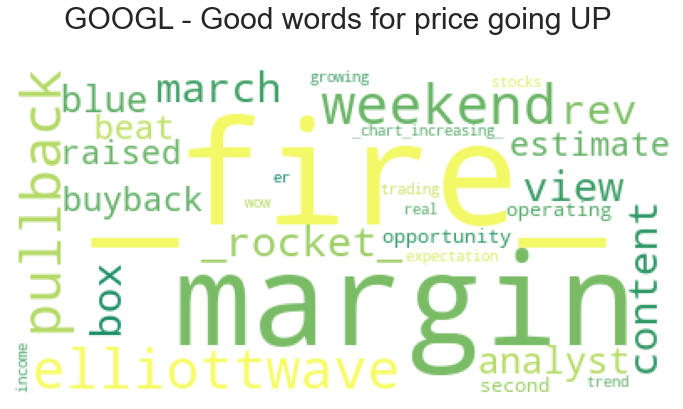

In [96]:
wordcloud_good = WordCloud(background_color='white', colormap='summer').generate_from_frequencies(good_words_dict)
plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud_good)
plt.axis("off")
plt.title('GOOGL - Good words for price going UP \n', fontdict={'fontsize':30});

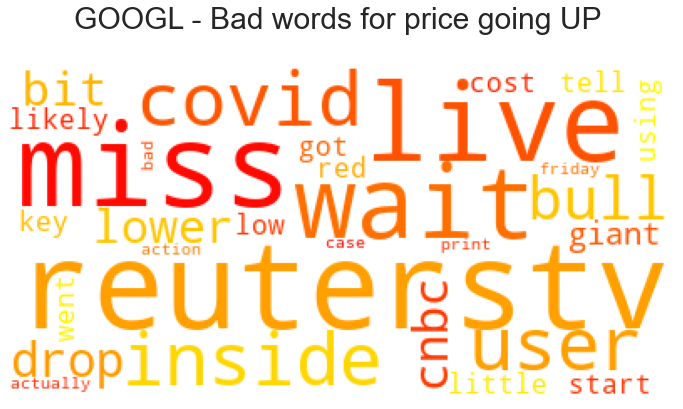

In [97]:
wordcloud_bad = WordCloud(background_color='white', colormap='autumn').generate_from_frequencies(bad_words_dict)
plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud_bad)
plt.axis("off")
plt.title('GOOGL - Bad words for price going UP \n', fontdict={'fontsize':30});

#### XOM

In [98]:
cloud_xom_good_words, cloud_xom_bad_words = get_words(xom_text, 30, 40)

In [99]:
good_words_dict = {}
bad_words_dict = {}

for w, p in zip(cloud_xom_good_words['word'], cloud_xom_good_words['probability']):
    good_words_dict[w] = round(p,2)
    
for w, p in zip(cloud_xom_bad_words['word'], cloud_xom_bad_words['probability']):
    bad_words_dict[w] = round(1-p,2)

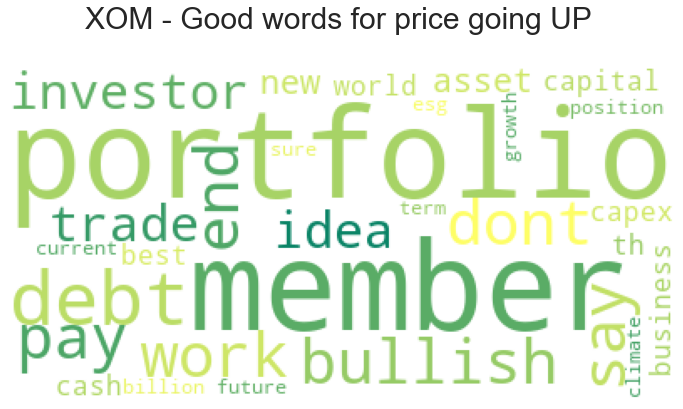

In [100]:
wordcloud_good = WordCloud(background_color='white', colormap='summer').generate_from_frequencies(good_words_dict)
plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud_good)
plt.axis("off")
plt.title('XOM - Good words for price going UP \n', fontdict={'fontsize':30});

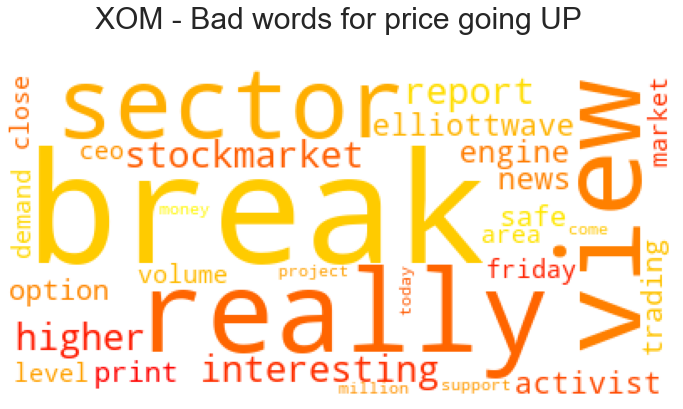

In [101]:
wordcloud_bad = WordCloud(background_color='white', colormap='autumn').generate_from_frequencies(bad_words_dict)
plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud_bad)
plt.axis("off")
plt.title('XOM - Bad words for price going UP \n', fontdict={'fontsize':30});

#### JPM

In [102]:
cloud_jpm_good_words, cloud_jpm_bad_words = get_words(jpm_text, 30, 50)

In [103]:
good_words_dict = {}
bad_words_dict = {}

for w, p in zip(cloud_jpm_good_words['word'], cloud_jpm_good_words['probability']):
    good_words_dict[w] = round(p,2)
    
for w, p in zip(cloud_jpm_bad_words['word'], cloud_jpm_bad_words['probability']):
    bad_words_dict[w] = round(1-p,2)

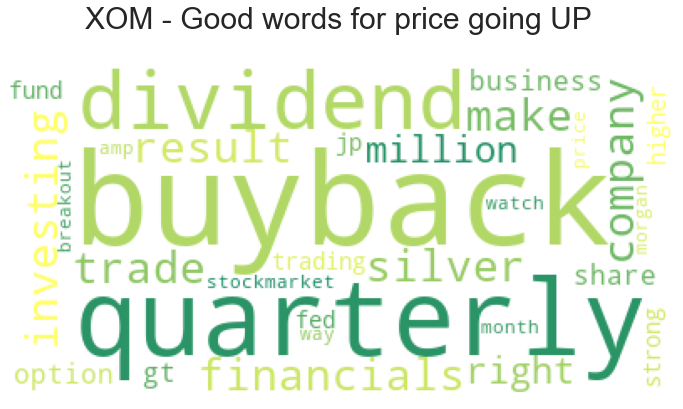

In [104]:
wordcloud_good = WordCloud(background_color='white', colormap='summer').generate_from_frequencies(good_words_dict)
plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud_good)
plt.axis("off")
plt.title('XOM - Good words for price going UP \n', fontdict={'fontsize':30});

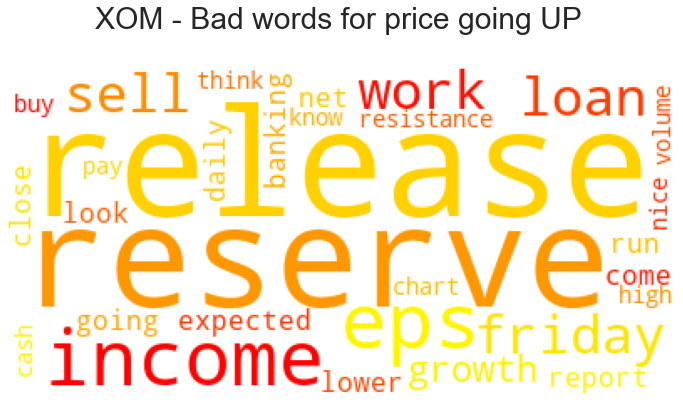

In [105]:
wordcloud_bad = WordCloud(background_color='white', colormap='autumn').generate_from_frequencies(bad_words_dict)
plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud_bad)
plt.axis("off")
plt.title('XOM - Bad words for price going UP \n', fontdict={'fontsize':30});